# Тестовое задание дла goznak

В рамках данной задачи предлагается решить несколько проблем, возникающих при работе с зашумленным звуком.

Решение предполагает построение модели, использующее стандартные ML практики или нейронные сети, ее обучение и тестирование.

Задача поделена на два этапа: 
1. Классификация (Junior): необходимо реализовать алгоритм, позволяющий определить, является ли аудиозапись зашумлённой или нет. 
2. Denoising (Middle): необходимо реализовать алгоритм, позволяющий избавиться от посторонних шумов в звуковом сигнале. 

## Описание данных:

Для обучения и тестирования модели предоставлена выборка mel-спектрограмм, построенная по чистым и зашумленным звуковым файлам с голосом человека. Чистым звуком считается звук голоса без посторонних шумов (возможно с паузами). Шумом на зашумленных аудиозаписях может являться любой посторонний звук, который можно услышать в повседневной жизни: звонок телефона, проезжающая машина, звуки от чайника, смех и т.д. 

В качестве данных предоставлено 14 тысяч пар mel-спектрограмм (чистый звук + зашумлённый звук), соответствующих звуковым файлам, все файлы разных длительностей. Из них 12 тысяч – тренировочная выборка, 2 тысячи – валидационная. Тестирование будет проводиться на закрытой выборке, состоящей из 2 тысяч mel-спектрограмм
.
Данные можно скачать по ссылке https://cloud.mail.ru/public/39UY/5gfMbWVHH, а именно: train.part1.rar и train.part2.rar - тренировочная выборка, val.rar - валидационная выборка. Пример данных доступен в Jupyter notebook (explore_data.rar).

Все данные разделены на чистые и зашумленные. Внутри каждой категории есть разделение по спикерам. Для каждого спикера есть набор из чистых данных и набор из зашумленных данных. Название файла с зашумленными данными соответствует названию файла с оригинальными данными.
Топология данных для тренировочной выборки (для тестовой идентична): 

- clean\
- - speaker1_id\
- - - spec_sample_1_1.npy 
- - - spec_sample_1_2.npy
- - - ...
- - speaker2_id\
- - - spec_sample_2_1.npy 
- - - spec_sample_2_2.npy 
- - - ... 
- - ...
- noise\
- - speaker1_id\
- - - spec_sample_1_1.npy 
- - - spec_sample_1_2.npy 
- - - ...
- - speaker2_id\
- - - spec_sample_2_1.npy 
- - - spec_sample_2_2.npy 
- - - ...
- - ... 

## Метрики:
Метрика для алгоритма классификации: Accuracy.

Метрика для алгоритма Denoising: MSE.

## Дополнительные условия 
Язык программирования: любой.

Библиотеки\фреймворки для ML\DL: любые.

Результатом задачи должны являться:

    * Скрипт(ы) для обучения
    * Скрипт(ы) для запуска
    * Readme с описанием алгоритмов и команд их запуска, – алгоритм должен принимать на вход файл mel-спектрограммы и решать задачу классификации или denoising.

# Распаковка файлов

In [1]:
!apt-get install -y unrar 1>/dev/null

In [2]:
!rm -Rf ./Goznak_ML_Tasks/

Архивчик с файлами предполагается скаченным

In [3]:
%%bash
unzip Goznak_ML_Tasks.zip

Archive:  Goznak_ML_Tasks.zip
   creating: Goznak_ML_Tasks/
 extracting: Goznak_ML_Tasks/Tasks description-3.docx  
 extracting: Goznak_ML_Tasks/explore_data.rar  
 extracting: Goznak_ML_Tasks/train.part1.rar  
 extracting: Goznak_ML_Tasks/train.part2.rar  
 extracting: Goznak_ML_Tasks/val.rar  


In [4]:
%%bash
cd Goznak_ML_Tasks
unrar x train.part2.rar 1>/dev/null
mv train train_
mv ./train_/train train
rmdir train_
rm train.part1.rar train.part2.rar

In [5]:
%%bash
cd Goznak_ML_Tasks
unrar x val.rar 1>/dev/null
mv val val_
mv ./val_/val ./ 
rmdir val_
rm val.rar

In [6]:
%%bash 
cd Goznak_ML_Tasks/
unrar x explore_data.rar 1>/dev/null

In [7]:
!du -hcxs ./Goznak_ML_Tasks/

3.3G	./Goznak_ML_Tasks/
3.3G	total


# Параметры ноутбучика

In [8]:
batch_size = 512
num_workers = 8
device = 'cuda'


# Датасет

In [9]:
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [10]:
class DenoiseDataset(Dataset):
    def __init__(self, root, has_target=True):
        self.root = root
        self.noisy = {
            npy.name: npy
            for subdir in (root/'noisy').iterdir()
            for npy in subdir.iterdir()
        }
        self.names = sorted(self.noisy.keys())
        self.has_target = has_target
        if self.has_target:
            self.clean = {
                npy.name: npy
                for subdir in (root/'clean').iterdir()
                for npy in subdir.iterdir()
            }
            assert self.names == sorted(self.clean.keys())
        
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, i):
        name = self.names[i]
        res = {
            'noisy': np.load(self.noisy[name]),
            'name': name
        }
        res['mask'] = np.ones_like(res['noisy'], dtype=np.uint8)
        if self.has_target:
            res['clean'] = np.load(self.clean[name])
        return res
        
train = DenoiseDataset(Path('Goznak_ML_Tasks/train'))
val = DenoiseDataset(Path('Goznak_ML_Tasks/val'))
len(train.names), len(val.names)

(12000, 2000)

Text(0.5, 1.0, 'length distribution')

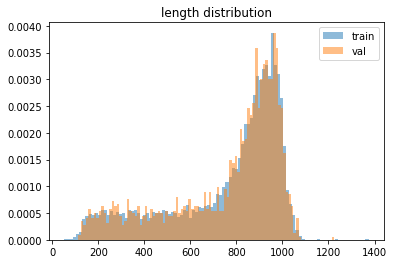

In [11]:
plt.hist([len(item['clean']) for item in train], bins=100, alpha=0.5, label='train', density=True);
plt.hist([len(item['clean']) for item in val], bins=100, alpha=0.5, label='val', density=True);
plt.legend();
plt.title('length distribution')

In [12]:
train_set = set([item.split('_')[0] for item in train.names])
val_set = set([item.split('_')[0] for item in val.names])
len(train_set), len(val_set), len(train_set.intersection(val_set))

(799, 150, 0)

Спикеры не пересекаются. Задача speaker independed

In [13]:
def loader_collate(lst):
    keys = ['noisy', 'mask']
    if 'clean' in lst[0]:
        keys.append('clean')
    res = {
        key: pad_sequence(
            [torch.Tensor(elem[key]) for elem in lst],
            batch_first=True
        )
        for key in keys
    }
    res['name'] = [record['name'] for record in lst]
    return res
        

train_loader = DataLoader(
    train, 
    batch_size=batch_size, 
    collate_fn=loader_collate,
    num_workers=num_workers
)
val_loader = DataLoader(
    val, 
    batch_size=batch_size, 
    collate_fn=loader_collate
)

for batch in train_loader:
    break

# Расчет метрик

In [14]:
import torch
from torch import nn

In [15]:
def to_device(device, data):
    if isinstance(data, dict):
        return {
            key: to_device(device, value)
            for key, value in data.items()
        }
    if isinstance(data, torch.Tensor):
        return data.to(device)
    return data

In [16]:
def masked_mean(vals, mask):
    batch_size = vals.shape[0]
    vals = vals.reshape(batch_size, -1)
    mask = mask.reshape(batch_size, -1)
    return (vals * mask).sum(dim=1) / mask.sum(dim=1)


def validate(model, loader):
    """
        Считает MSE по каждому семплу, потом по ним усредняет
    """
    model.eval()
    torch.set_grad_enabled(False)
    squared_errors = []
    for batch in tqdm(loader, leave=False):
        batch = to_device(device, batch)
        batch_size = len(batch['clean'])
        model_out = model(batch)
        squared_error = (model_out - batch['clean'])**2
        squared_errors.extend(
            masked_mean(squared_error, batch['mask'])\
            .cpu().numpy().tolist()
        )
    squared_errors = np.array(squared_errors)

    return {
        'mse': np.array(squared_errors).mean()
    }
    return errors.mean()

## Копирующий baseline

In [17]:
class Copy(nn.Module):
    def forward(self, batch):
        return batch['noisy']

copy = Copy()
validate(copy, train_loader), validate(copy, val_loader)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

({'mse': 0.13258741769323312}, {'mse': 0.1328126230945927})

## Константные предикты

In [18]:
def calc_const_baseline(loader):
    res = []
    for batch in tqdm(loader, leave=False):
        batch['clean'].mean(axis=0)
        means = batch['clean'].sum(dim=1) / batch['mask'].sum(dim=1)
        res.append(means.cpu().numpy())
    return torch.Tensor(np.concatenate(res).mean(axis=0))

const_baseline = calc_const_baseline(train_loader)

class ConstModel(nn.Module):
    def __init__(self, const_data):
        super().__init__()
        self.const = nn.Parameter(const_data)
        
    def forward(self, batch):
        batch_size, seq_len, _  = batch['noisy'].shape
        res = self.const.reshape(1, 1, 80)
        return res.repeat(batch_size, seq_len, 1)
    
const_model = ConstModel(const_baseline).to(device)    
validate(const_model, train_loader), validate(const_model, val_loader)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

({'mse': 0.17872912955842912}, {'mse': 0.18071545355021953})

# Обучение сети

In [19]:
from torch import optim

In [20]:
for sample in val_loader:
    break
sample = to_device(device, sample)

In [21]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.LSTM(
            input_size=80, 
            hidden_size=80,
            batch_first=True
        )
        
    def forward(self, batch):
        return self.net(batch['noisy'])[0]
        
model = Model().to(device)
model(sample).shape

torch.Size([512, 1062, 80])

In [22]:
def train_loss(batch, model_out):
    error = (model_out - batch['clean'])**2
    return masked_mean(error, batch['mask']).mean()

In [23]:
model = Model().to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
history = {'train': [], 'val': []}
for epoch in tqdm(range(30)):
    model.train()
    torch.set_grad_enabled(True)
    for batch in tqdm(train_loader, leave=False):
        batch = to_device(device, batch)
        opt.zero_grad()
        model_out = model(batch)
        loss = train_loss(batch, model_out)
        loss.backward()
        opt.step()
    history['train'].append(validate(model, train_loader))
    history['val'].append(validate(model, val_loader))
    print(history['train'][-1], history['val'][-1])
final_model = model

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.10832841082351903} {'mse': 0.1085808018874377}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.08852702678227797} {'mse': 0.08875482958834618}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.08821635944442824} {'mse': 0.08871116793435067}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.08396647036184246} {'mse': 0.08457948738709092}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.0827424632726858} {'mse': 0.08319814015738666}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.0808045478418159} {'mse': 0.08128581816703082}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.08317942396691069} {'mse': 0.08365036535263061}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.07811046077264473} {'mse': 0.07855735269747674}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.07284615771394844} {'mse': 0.07311530607379974}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.07159442596773928} {'mse': 0.0718515480319038}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.0702100721760653} {'mse': 0.07042858254536986}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06888859334386264} {'mse': 0.06905635701678693}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06885489844965438} {'mse': 0.06894621756207198}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06819121672182034} {'mse': 0.06840932488720865}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06756907946057618} {'mse': 0.06763229798059911}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06644296011452873} {'mse': 0.06662507951073349}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06702691545523703} {'mse': 0.06716307660005987}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.0646329679543463} {'mse': 0.06455811868607998}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06543176845104123} {'mse': 0.06566725369542838}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06380364698482056} {'mse': 0.06379575708974153}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06496073763103535} {'mse': 0.06493968679197133}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06640609940808888} {'mse': 0.0664434831533581}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06403020068227003} {'mse': 0.06407094220537693}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06371718116275345} {'mse': 0.06376398276630789}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06254102701197067} {'mse': 0.06244920187909156}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.062128801001391065} {'mse': 0.06194720014650375}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06169941164040938} {'mse': 0.06161089977901429}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06239312662354981} {'mse': 0.06216154240071774}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.061009536860045045} {'mse': 0.06074953989032656}


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'mse': 0.06268907928404709} {'mse': 0.06258407451119274}


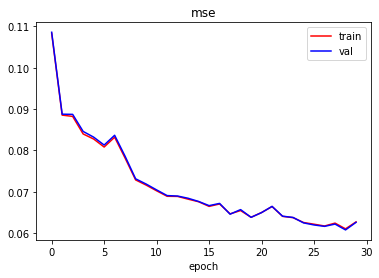

In [24]:
def plot_metric(history, name):
    plt.plot([record[name] for record in history['train']], c='r', label='train')
    plt.plot([record[name] for record in history['val']], c='b', label='val')
    plt.legend()
    plt.title(name)
    plt.xlabel('epoch')

plot_metric(history, 'mse')

Простые baseline'ы побиты. Модель чему-то научилась.

# inference

Здесь описана процедура inference'а. Для теста берется валидационный датасет. Для применения к произвольному датасету, нужно указать к нему путь в строке
```
    inference = DenoiseDataset(Path('<path_to_dataset>'), has_target=False)

```

In [25]:
%%bash
rm -Rf ./inference
mkdir -p inference
cp -r ./Goznak_ML_Tasks/val/noisy ./inference

In [26]:
inference = DenoiseDataset(Path('./inference'), has_target=False)
inference_loader = DataLoader(
    inference, 
    batch_size=batch_size, 
    num_workers=num_workers,
    collate_fn=loader_collate
)
final_model.eval()
torch.set_grad_enabled(False)
for batch in tqdm(inference_loader, leave=False):
    batch =to_device(device, batch)
    model_out = final_model(batch)
    for num, name in enumerate(batch['name']):
        target = inference.root/'clean'/name.split('_')[0]/name
        target.parent.mkdir(exist_ok=True, parents=True)
        seq_len = batch['mask'][num].sum().long().cpu().numpy()
        predict = model_out[num,0:seq_len].cpu().numpy()
        np.save(target, predict)

  0%|          | 0/4 [00:00<?, ?it/s]

Просто для проверки, что все записалось.

In [27]:
inference_test = DenoiseDataset(Path('./inference/'))
inference_test[0]['noisy'].shape

(685, 80)